# Report
---

Description of methods and results. Introduction.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [28]:
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import logging
import numpy as np
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [14]:
from qrl_navigation.model import DuelingQNetwork
from qrl_navigation.replay_buffer import ReplayWeightedBuffer
from qrl_navigation.agent import WeightedAgent, Agent
from qrl_navigation.environment import BananaMazeEnv
from qrl_navigation.training import dqn_training
import torch
import pickle
import time

In [102]:
def get_best_avg_score(scores, n_samples):
    cs = np.cumsum(scores)
    diff = cs[n_samples:] - cs[:-n_samples]
    idxs = np.argsort(diff)[::-1][:3]
    avg_scores = diff[idxs] / n_samples
    
    return idxs + n_samples, avg_scores

## Experiment data

### Metadata insights

### Evaluation of model

In [49]:
meta = pickle.load(open('../experiments/dueling/meta.pickle', 'rb'))

In [50]:
meta['agent']

'Agent(state_size=37, action_size=4, fc_units=[64, 64], device="cuda", dueling=True)'

In [22]:
agent = eval(meta['agent'])

In [23]:
meta['model_path']

'../experiments/basic/model.pt'

In [ ]:
agent.load(meta['model_path'])

In [4]:
maze_env = BananaMazeEnv(train_mode=True)

DEBUG:unityagents:The true file name is Banana
DEBUG:unityagents:This is the launch string /home/adam/code/qrl_navigation/notebooks/../bin/unity_banana_maze/Banana.x86_64
INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [18]:
state = maze_env.reset()
score = 0
for step in range(1000):
    action = agent.act(state, 0.01)
    next_state, reward, done = maze_env.step(action)
    agent.step(state, action, reward, next_state, done)
    state = next_state
    score += reward
    if reward != 0:
        print(f'Score update: {score}')
    time.sleep(0.05)
    if done:
        break
print(f'Final score is {score}')

Score update: -1.0
Score update: 0.0
Score update: 1.0
Score update: 2.0
Score update: 3.0
Score update: 4.0
Score update: 5.0
Score update: 6.0
Score update: 7.0
Score update: 8.0
Score update: 9.0
Score update: 10.0
Score update: 11.0
Score update: 12.0
Score update: 13.0
Score update: 14.0
Score update: 15.0
Final score is 15.0


In [19]:
maze_env.close()

## Evaluation of results

### Introduction to methods

### Comparison of score developement

In [96]:
meta_dueling = pickle.load(open('../experiments/dueling/meta.pickle', 'rb'))
meta_dueling_w = pickle.load(open('../experiments/dueling_weighted/meta.pickle', 'rb'))
meta_basic = pickle.load(open('../experiments/basic/meta.pickle', 'rb'))
meta_basic_w = pickle.load(open('../experiments/basic_weighted/meta.pickle', 'rb'))


data_dueling = pd.DataFrame({'scores': meta_dueling['scores'], 'iterations': range(len(meta_dueling['scores']))})
data_basic = pd.DataFrame({'scores': meta_basic['scores'], 'iterations': range(len(meta_basic['scores']))})
data_dueling_w = pd.DataFrame({'scores': meta_dueling_w['scores'], 'iterations': range(len(meta_dueling_w['scores']))})
data_basic_w = pd.DataFrame({'scores': meta_basic_w['scores'], 'iterations': range(len(meta_basic_w['scores']))})

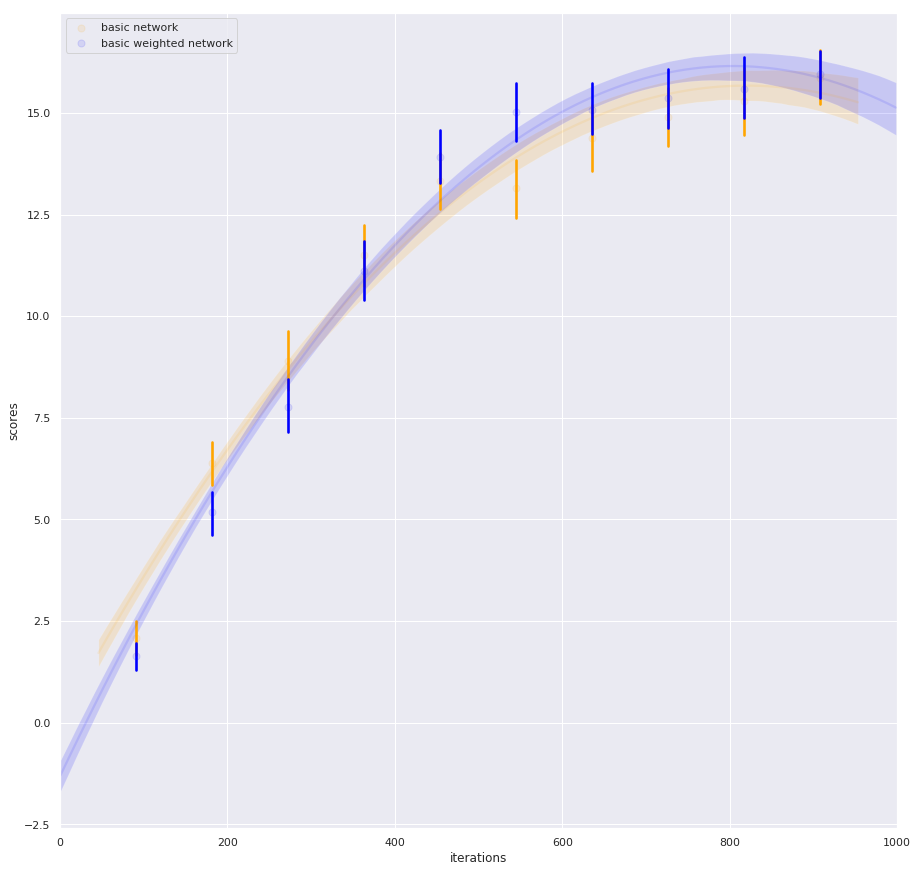

In [116]:
plt.figure(figsize=(15, 15))
ax = plt.gca()
sns.regplot(x='iterations', y='scores', data=data_basic, ax=ax, order=2, x_bins=10, line_kws={'alpha':0.1}, scatter_kws={'alpha':0.1}, color='orange', label='basic network')
sns.regplot(x='iterations', y='scores', data=data_basic_w, ax=ax, order=2, x_bins=10, line_kws={'alpha':0.1}, scatter_kws={'alpha':0.1}, color='blue', label='basic weighted network')
plt.xlim(0, 1000)
plt.legend()

In [132]:
print(f'Percentile scores, non-weighted vs. weighted:')
print(np.percentile(meta_basic['scores'], [5, 25, 50, 75, 95]))
print(np.percentile(meta_basic_w['scores'], [5, 25, 50, 75, 95]))

Percentile scores, non-weighted vs. weighted:
[  1.   7.  12.  16.  20.]
[  1.   7.  13.  16.  20.]


In [131]:
print(f'Mean score after 1000 runs, non-weighted vs. weighted: {np.mean((meta_basic["scores"]))} vs. {np.mean((meta_basic_w["scores"]))}')

Mean score after 1000 runs, non-weighted vs. weighted: 11.336 vs. 11.395


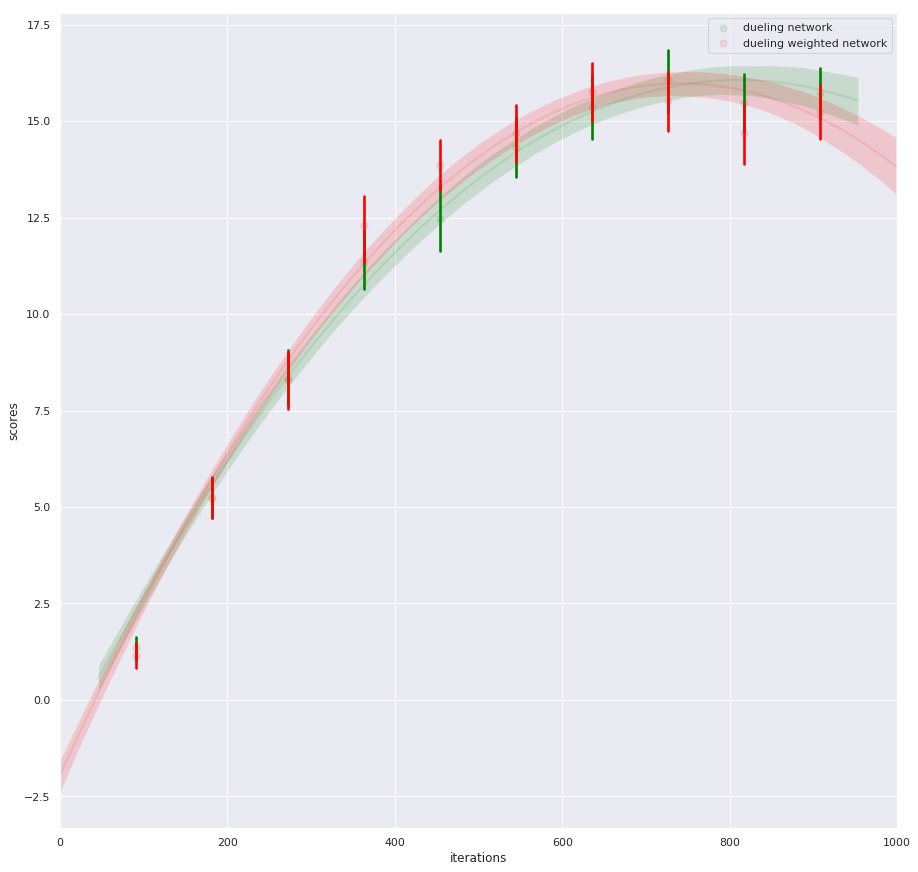

In [117]:
plt.figure(figsize=(15, 15))
ax = plt.gca()
sns.regplot(x='iterations', y='scores', data=data_dueling, ax=ax, order=2, x_bins=10, line_kws={'alpha':0.1}, scatter_kws={'alpha':0.1}, color='green', label='dueling network')
sns.regplot(x='iterations', y='scores', data=data_dueling_w, ax=ax, order=2, x_bins=10, line_kws={'alpha':0.1}, scatter_kws={'alpha':0.1}, color='red', label='dueling weighted network')
plt.xlim(0, 1000)
plt.legend()

In [133]:
print(f'Percentile scores, non-weighted vs. weighted:')
print(np.percentile(meta_dueling['scores'], [5, 25, 50, 75, 95]))
print(np.percentile(meta_dueling_w['scores'], [5, 25, 50, 75, 95]))

Percentile scores, non-weighted vs. weighted:
[  0.   6.  12.  16.  21.]
[  0.   7.  12.  16.  20.]


In [135]:
print(f'Mean score after 1000 runs, non-weighted vs. weighted: {np.mean((meta_dueling["scores"]))} vs. {np.mean((meta_dueling_w["scores"]))}')

Mean score after 1000 runs, non-weighted vs. weighted: 11.29 vs. 11.349


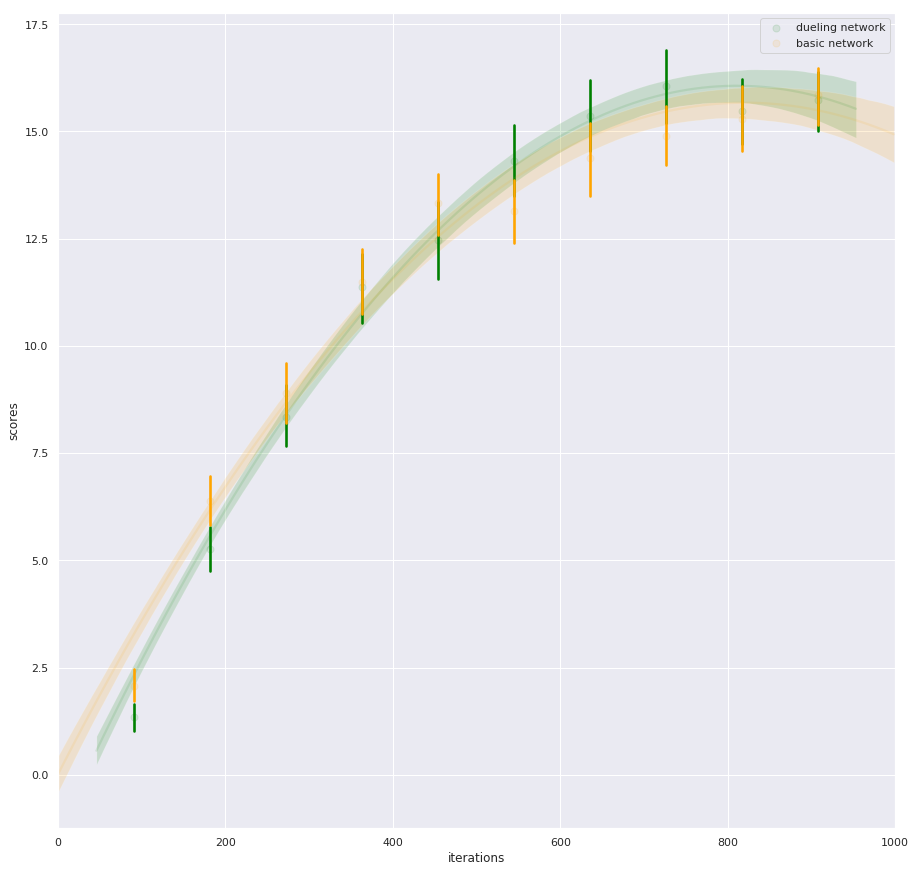

In [118]:
plt.figure(figsize=(15, 15))
ax = plt.gca()
sns.regplot(x='iterations', y='scores', data=data_dueling, ax=ax, order=2, x_bins=10, line_kws={'alpha':0.1}, scatter_kws={'alpha':0.1}, color='green', label='dueling network')
sns.regplot(x='iterations', y='scores', data=data_basic, ax=ax, order=2, x_bins=10, line_kws={'alpha':0.1}, scatter_kws={'alpha':0.1}, color='orange', label='basic network')
plt.xlim(0, 1000)
plt.legend()

In [136]:
print(f'Percentile scores, basic vs. dueling:')
print(np.percentile(meta_basic['scores'], [5, 25, 50, 75, 95]))
print(np.percentile(meta_dueling['scores'], [5, 25, 50, 75, 95]))

Percentile scores, basic vs. dueling:
[  1.   7.  12.  16.  20.]
[  0.   6.  12.  16.  21.]


In [137]:
print(f'Mean score after 1000 runs, basic vs. dueling: {np.mean((meta_basic["scores"]))} vs. {np.mean((meta_dueling["scores"]))}')

Mean score after 1000 runs, basic vs. dueling: 11.336 vs. 11.29


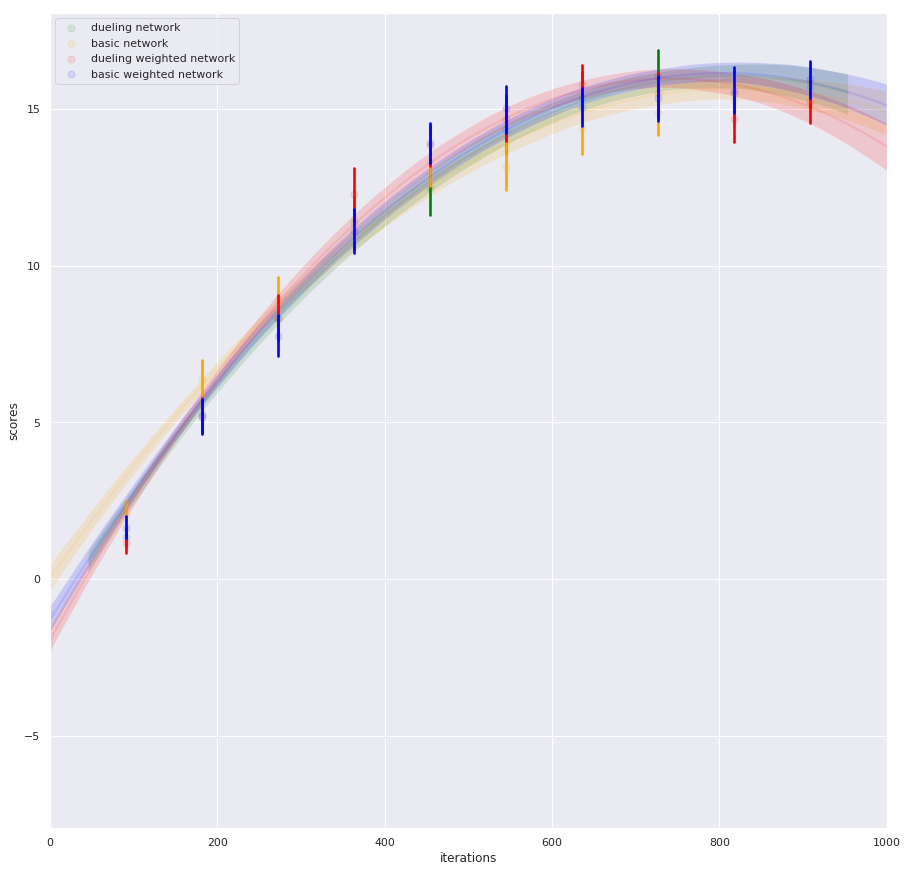

In [101]:
plt.figure(figsize=(15, 15))
ax = plt.gca()
sns.regplot(x='iterations', y='scores', data=data_dueling, ax=ax, order=2, x_bins=10, line_kws={'alpha':0.1}, scatter_kws={'alpha':0.1}, color='green', label='dueling network')
sns.regplot(x='iterations', y='scores', data=data_basic, ax=ax, order=2, x_bins=10, line_kws={'alpha':0.1}, scatter_kws={'alpha':0.1}, color='orange', label='basic network')
sns.regplot(x='iterations', y='scores', data=data_dueling_w, ax=ax, order=2, x_bins=10, line_kws={'alpha':0.1}, scatter_kws={'alpha':0.1}, color='red', label='dueling weighted network')
sns.regplot(x='iterations', y='scores', data=data_basic_w, ax=ax, order=2, x_bins=10, line_kws={'alpha':0.1}, scatter_kws={'alpha':0.1}, color='blue', label='basic weighted network')
plt.xlim(0, 1000)
plt.legend()

### Max scores occurance

In [138]:
get_best_avg_score(meta_basic['scores'], 100)

(array([998, 997, 995]), array([ 16.37,  16.35,  16.32]))

In [139]:
get_best_avg_score(meta_dueling['scores'], 100)

(array([794, 988, 842]), array([ 16.22,  16.21,  16.18]))

In [140]:
get_best_avg_score(meta_basic_w['scores'], 100)

(array([988, 996, 989]), array([ 16.15,  16.12,  16.11]))

In [141]:
get_best_avg_score(meta_dueling_w['scores'], 100)

(array([705, 687, 727]), array([ 15.87,  15.86,  15.86]))

### Conclusions

## Next steps